In [1]:
import numpy as np
import os
from patchify import patchify  # Only to handle large images
from PIL import Image  # Use Pillow for image handling
from datasets import Dataset

In [2]:
# Define paths for images and masks
image_dir = r"E:/Random Python Scripts/Tata HaxS/SAM/Dataset/train/images"
mask_dir = r"E:/Random Python Scripts/Tata HaxS/SAM/Dataset/train/masks"

In [3]:
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
mask_files = [f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

In [4]:
# Initialize lists to hold the images and masks
all_img_patches = []
all_mask_patches = []

# Process images
for img_file in image_files:
    # Load each image using Pillow
    try:
        # Convert grayscale image to RGB
        large_image = Image.open(os.path.join(image_dir, img_file)).convert('RGB')
    except Exception as e:
        print(f"Error loading image: {img_file} - {e}")
        continue
    
    # Convert the Pillow image to a NumPy array
    large_image_np = np.array(large_image)
    
    # Append the entire image array to the list
    all_img_patches.append(large_image_np)

# Convert the list of images to a NumPy array
images = np.array(all_img_patches)

# Process masks
for mask_file in mask_files:
    # Load each mask using Pillow
    try:
        large_mask = Image.open(os.path.join(mask_dir, mask_file)).convert('L')  # Load as grayscale
    except Exception as e:
        print(f"Error loading mask: {mask_file} - {e}")
        continue
    
    # Convert the Pillow mask to a NumPy array
    large_mask_np = np.array(large_mask)

    # Normalize mask values to [0, 1] and append to the list
    single_patch_mask = (large_mask_np / 255.).astype(np.uint8)  # Normalize mask values
    all_mask_patches.append(single_patch_mask)

# Convert the list of masks to a NumPy array
masks = np.array(all_mask_patches)

In [5]:
print(images.shape)
print(masks.shape)

(378, 540, 960, 3)
(378, 540, 960)


In [6]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in images],
    "label": [Image.fromarray(mask) for mask in masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [7]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 378
})

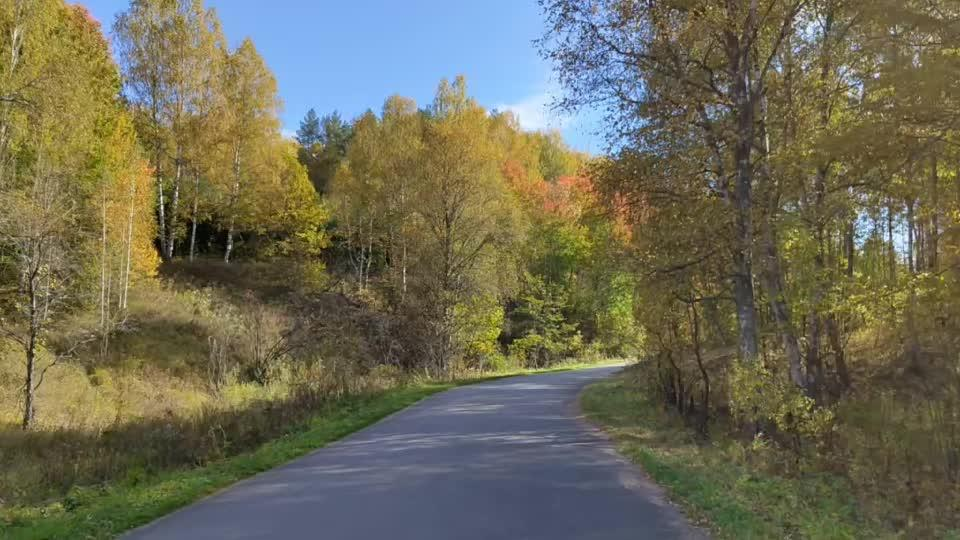

In [8]:
example = dataset[0]
image = example["image"]
image

(-0.5, 959.5, 539.5, -0.5)

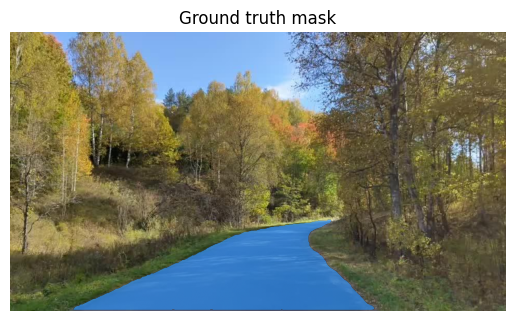

In [9]:
import matplotlib.pyplot as plt
import numpy as np 

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [10]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [11]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [12]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [13]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [14]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (540, 960)


In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [16]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 540, 960])


In [17]:
batch["ground_truth_mask"].shape

torch.Size([2, 540, 960])

In [18]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [19]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [20]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 5

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|                                                                                          | 0/189 [00:01<?, ?it/s]


AssertionError: ground truth has different shape (torch.Size([2, 1, 540, 960])) from input (torch.Size([2, 1, 256, 256]))